In [1]:
%pylab inline
import pandas as pd

Populating the interactive namespace from numpy and matplotlib


# Actionable scRNA-seq clusters

## Simulated data

To assess whether an approach is reasonable, it is good to make some simulations of the ideal case. To simulate cells from different cell types, I make use of 1) a theory that cell types are defined my "pathways" of covarying genes, and 2) observations from interpreting principal component analysis from many datasets.

With this in mind, simulation is done by for each cell type creating a multivarate normal distribution for each cell type, which have increased mean and covariance for a defining "module" of genes. From this distribution a number of cells are sampled, and expression values are pushed through a softplus function to immitate the nonnegative scale and properties of log(counts + 1).

In [2]:
from NaiveDE import simulate

In [3]:
data = simulate.simulate_cell_types(num_clusters=10,
                                    num_cells=1000,
                                    num_markers_per_cluster=20,
                                    num_bg_genes=300,
                                    marker_expr=1.8,
                                    marker_covar=0.6)


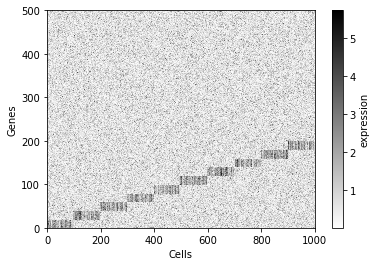

In [4]:
simulate.plot_data(data)

In [5]:
from sklearn.decomposition import PCA

In [6]:
pca = PCA(15)

In [7]:
Y = pca.fit_transform(data)

In [8]:
from sklearn.manifold import TSNE

In [9]:
tsne = TSNE()

In [10]:
YY = tsne.fit_transform(Y)

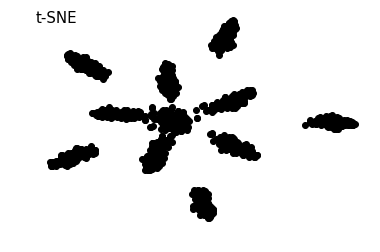

In [11]:
figsize(6, 4)
plt.scatter(YY[:, 0], YY[:, 1], c='k')
plt.axis('off');
plt.annotate('t-SNE', (0, 1), ha='left', va='top', size=15, xycoords='axes fraction');

The most unrealistic part of this simulation is probably the uniform distribution of cell numbers per cell type.

To cluster cells it is pretty effective to work in the space of a number or principal components. I like to use Bayesian Gaussian mixture models to group cells into clusters. First let's cluster with an overly large number of clusters.

In [12]:
from sklearn.mixture import BayesianGaussianMixture

In [13]:
def get_clusters(K):
    gmm = BayesianGaussianMixture(K, max_iter=1000)
    gmm.fit(Y)
    c = gmm.predict(Y)
    return c

In [14]:
def plot_clusters(c):
    plt.scatter(YY[:, 0], YY[:, 1], c=c, cmap=cm.YlOrRd, vmin=-c.max() / 3)
    plt.annotate('t-SNE', (0, 1), ha='left', va='top', size=15, xycoords='axes fraction');
    plt.axis('off');

In [15]:
c = get_clusters(25)

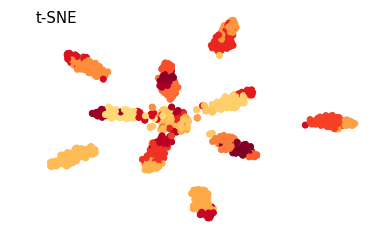

In [16]:
plot_clusters(c)

For a cluster to be useful, in followup experiments we must be able to define it with a small number of genes. That is, there should be some genes which will allow us to predict whether a particular cell belongs to the cell type or not. It is not impossible functional cell types are defined by hugely complex nonlinear interactions of hundreds of genes. But in practice, nobody knows what to do with these cell types.

The definition of an actionable cell type as one we can predict leads to predictive models. In particular I think regularised logistic regression is good for this. By controlling the regularisation so that each cluster has a "marker budget" of only a handful genes, we can ensure that a few markers can predict the types.

ROC curves from the predicted assignment probabilites in logistic regression is one handy way to assess whether we are able to predict the cell types correctly. Here we split the data into 50% training and testing, train logistic regression, then create the ROC curve for the test data, for each cell type.

The printed numbers in the training command are the number of positive markers for each cell type. I interacticely change the sparsity parameter to keep these numbers generally low. In this regard this is all quite supervised and far from automated.

In [17]:
from NaiveDE import cell_types

In [18]:
test_prob, test_truth, lr_res, lr = cell_types.logistic_model(data, c, sparsity=0.5)

[26 24 34 31  8 31 10 10 42 24 17  8 10 39 17 39  5  7 12  7 21 19 10  9
 14]


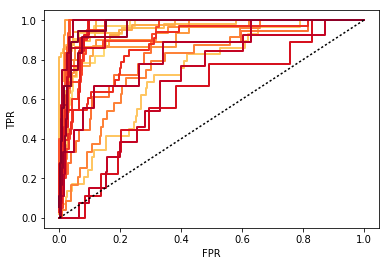

In [19]:
figsize(6, 4)
cell_types.plot_roc(test_prob, test_truth, lr)

A number of the clusters are relatively close to the unit line, indicating that we have a hard time predicting these, and they will not end up being actionable. So we decrease the K and try again. We iterate this procedure until we are happy with the predictability of the clusters.

In [20]:
figsize(3, 5)
def make_iteration(K, C):
    c = get_clusters(K)
    test_prob, test_truth, lr_res, lr = cell_types.logistic_model(data, c, sparsity=C)

    plt.subplot(2, 1, 1)
    plot_clusters(c)
    plt.title(f'K = {K}')

    plt.subplot(2, 1, 2)
    cell_types.plot_roc(test_prob, test_truth, lr)
    
    return c, lr_res

[ 1  5  4 16  9  6  3  1  1  3 10  7  7 12 11  1  4  5 14 10]


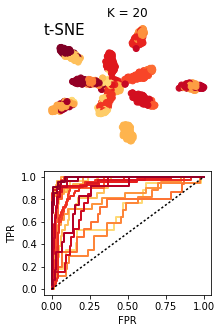

In [21]:
make_iteration(20, 0.1);

[13  2 15 12  9  1 15  8  9  8 13 13  6  7 10]


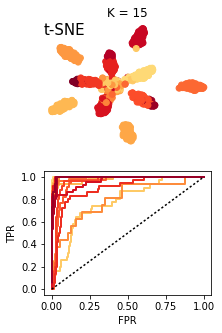

In [22]:
make_iteration(15, 0.1);

[11 11  5 13 12  0 14 15 14  8 12 13 10]


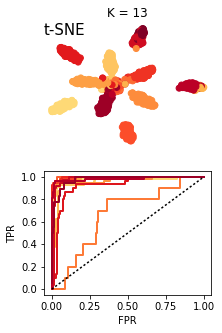

In [23]:
make_iteration(13, 0.1);

[ 5 13 12 11 15  9 13 15  0 16 14 14]


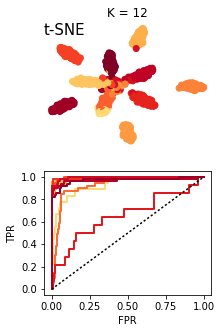

In [24]:
make_iteration(12, 0.1);

[13 13  0 15 12 12 14 13 12 14 11]


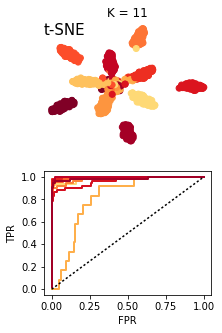

In [25]:
make_iteration(11, 0.1);

[11 13 14 13 14 18 14 13 13 15]


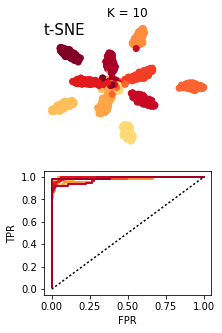

In [26]:
c, lr_res = make_iteration(10, 0.1);

[ 7 16  8 17  6]


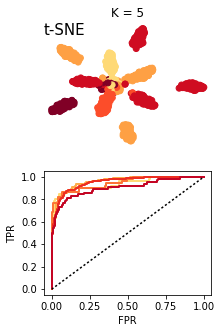

In [27]:
make_iteration(5, 0.03);

[ 5 18 10]


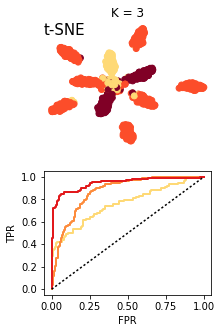

In [28]:
figsize(3, 5)
make_iteration(3, 0.025);

Here I have also plotted cases of "under clustering" the data. The larger clusters are still pretty predictice, but we would want to maximize the number of clusters which would be experimentally actionable.

In the case of K=10 (which is what we simulated), we can also look at which genes the predictive model is using for each cell type. We can use the `get_top_markers` command to extract the `N` largest weights for each class in a handy table.

In [29]:
top_markers = cell_types.get_top_markers(lr_res, 5)

To visualise how these weight relate the expression of cells with different cluster annotations, we can plot a "marker map", which sorts cells by cluster, and plots the top marker genes in corresponding order on the Y axis. This is a very common plot in scRNA-seq cluster studies.

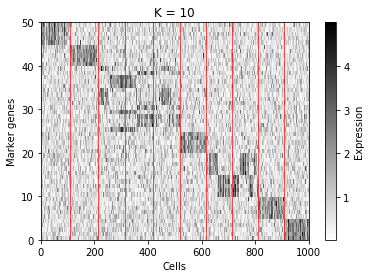

In [30]:
figsize(6, 4)
cell_types.plot_marker_map(data, c, top_markers)
plt.title('K = 10');

We see that structure we simulated is large recovered! The diagonal blocks indicate genes which predict the cell types.